In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from sqlalchemy import create_engine
import json

Connection

In [3]:
def create_connection():
    try:
        with open('../credentials.json') as f:
            credentials = json.load(f)
        
        user = credentials['user']
        password = credentials['password']
        host = credentials['host']
        port = credentials['port']
        database = 'diabetes_data'
        
        connection = psycopg2.connect(
            dbname=database,
            user=user,
            password=password,
            host=host,
            port=port
        )
        print("¡Conexión exitosa!")
        return connection
    except psycopg2.OperationalError as e:
        print(f"Error al conectar a la base de datos: {e}")
        return None

# Establish the connection
connection = create_connection()

# Load data from the PostgreSQL table into a pandas DataFrame
query = "SELECT * FROM diabetes_data"
df = pd.read_sql(query, connection)

# Display the first few rows of the DataFrame
df.head()

¡Conexión exitosa!


C:\Users\USER\AppData\Local\Temp\ipykernel_42220\3734632416.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


,patientid,age,gender,ethnicity,socioeconomicstatus,educationlevel,bmi,smoking,alcoholconsumption,physicalactivity,...,tinglinghandsfeet,qualityoflifescore,heavymetalsexposure,occupationalexposurechemicals,waterquality,medicalcheckupsfrequency,medicationadherence,healthliteracy,diagnosis,doctorincharge
0,6000,44,0,1,2,1,32.985284,1,4.499364662559289,2.443385277880059,...,1,73.765109,0,0,0,1.7827242506960626,4.486979557412981,7.2113489367727475,1,Confidential
1,6001,51,1,0,1,2,39.916764,0,1.578919022031171,8.301264419669659,...,0,91.445753,0,0,1,3.381069654567674,5.961704862944367,5.024612227805186,1,Confidential
2,6002,89,1,0,1,3,19.782251,0,1.1773011585548998,6.103395048386896,...,0,54.485744,0,0,0,2.701018729497643,8.950820518722507,7.0349436990025485,0,Confidential
3,6003,21,1,1,1,2,32.376881,1,1.714621007745527,8.64546518551969,...,0,77.866758,0,0,1,1.4090558394059216,3.1247685708774133,4.717774284423961,0,Confidential
4,6004,27,1,0,1,3,16.808600,0,15.4625488312587,4.62938308903732,...,0,37.731808,0,0,0,1.218452269419564,6.977741342165485,7.887940037735355,0,Confidential


Cleanning

In [10]:
# valores faltantes
missing_values = df.isnull().sum()
print("Valores faltantes por columna:\n", missing_values)

# filas duplicadas utilizando 'patientid'
duplicate_rows = df[df.duplicated(subset='patientid', keep=False)]
print(f"Número de filas duplicadas: {duplicate_rows.shape[0]}")

# Eliminamos filas duplicadas si es necesario
df = df.drop_duplicates(subset='patientid')

# convertimos variables categóricas a tipo 'category'
categorical_columns = [
    'gender', 'ethnicity', 'socioeconomicstatus', 'educationlevel', 
    'smoking', 'familyhistorydiabetes', 'gestationaldiabetes', 'polycysticovarysyndrome', 
    'previousprediabetes', 'hypertension', 'antihypertensivemedications', 
    'statins', 'antidiabeticmedications', 'frequenturination', 'excessivethirst', 
    'unexplainedweightloss', 'blurredvision', 'slowhealingsores', 'tinglinghandsfeet', 
    'heavymetalsexposure', 'occupationalexposurechemicals', 'waterquality', 'diagnosis'
]

# convertimos las columnas categóricas al tipo 'category'
df[categorical_columns] = df[categorical_columns].astype('category')

# verificamos la conversión
print("Tipos de datos después de la conversión:\n", df.dtypes[categorical_columns])

# convertimos columnas numéricas a tipo numérico y manejar errores
numeric_columns = [
    'age', 'bmi', 'systolicbp', 'diastolicbp', 'fastingbloodsugar', 'hba1c', 
    'serumcreatinine', 'bunlevels', 'cholesteroltotal', 'cholesterolldl', 
    'cholesterolhdl', 'cholesteroltriglycerides', 'physicalactivity', 
    'alcoholconsumption', 'medicalcheckupsfrequency', 'medicationadherence', 
    'healthliteracy', 'fatiguelevels', 'dietquality', 'sleepquality'
]

# convertimos a tipo numérico y forzar a NaN en caso de error
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# identicamos outliers y verificación de rangos esperados
expected_ranges = {
    'age': (20, 90),
    'bmi': (15, 40),
    'systolicbp': (90, 180),
    'diastolicbp': (60, 120),
    'fastingbloodsugar': (70, 200),
    'hba1c': (4.0, 10.0),
    'serumcreatinine': (0.5, 5.0),
    'bunlevels': (5, 50),
    'cholesteroltotal': (150, 300),
    'cholesterolldl': (50, 200),
    'cholesterolhdl': (20, 100),
    'cholesteroltriglycerides': (50, 400),
    'physicalactivity': (0, 10),
    'alcoholconsumption': (0, 20),
    'medicalcheckupsfrequency': (0, 4),
    'medicationadherence': (0, 10),
    'healthliteracy': (0, 10),
    'fatiguelevels': (0, 10),
    'dietquality': (0, 10),
    'sleepquality': (4, 10)
}

def check_ranges(data, ranges):
    out_of_range = {}
    for column, (min_val, max_val) in ranges.items():
        if column in data.columns:
            out_of_range[column] = data[(data[column] < min_val) | (data[column] > max_val)].shape[0]
    return out_of_range

out_of_range_counts = check_ranges(df, expected_ranges)
print("Número de valores fuera de los rangos esperados:\n", out_of_range_counts)




Valores faltantes por columna:
 patientid                        0
age                              0
gender                           0
ethnicity                        0
socioeconomicstatus              0
educationlevel                   0
bmi                              0
smoking                          0
alcoholconsumption               0
physicalactivity                 0
dietquality                      0
sleepquality                     0
familyhistorydiabetes            0
gestationaldiabetes              0
polycysticovarysyndrome          0
previousprediabetes              0
hypertension                     0
systolicbp                       0
diastolicbp                      0
fastingbloodsugar                0
hba1c                            0
serumcreatinine                  0
bunlevels                        0
cholesteroltotal                 0
cholesterolldl                   0
cholesterolhdl                   0
cholesteroltriglycerides         0
antihypertensivemedicat

Export

In [12]:
# exportamos datos limpios a la base de datos
with open('../credentials.json') as f:
    credentials = json.load(f)

user = credentials['user']
password = credentials['password']
host = credentials['host']
port = credentials['port']
database = 'diabetes_data'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}'
engine = create_engine(connection_string)

df.to_sql('diabetes_data_clean', engine, if_exists='replace', index=False)
print("Datos exportados exitosamente a la tabla 'diabetes_data_clean' en PostgreSQL.")

# comprobamos
print("DataFrame procesado:")
print(df.head())
print(df.dtypes)

Datos exportados exitosamente a la tabla 'diabetes_data_clean' en PostgreSQL.
DataFrame procesado:
   patientid  age gender ethnicity socioeconomicstatus educationlevel  \
0       6000   44      0         1                   2              1   
1       6001   51      1         0                   1              2   
2       6002   89      1         0                   1              3   
3       6003   21      1         1                   1              2   
4       6004   27      1         0                   1              3   

         bmi smoking  alcoholconsumption  physicalactivity  ...  \
0  32.985284       1            4.499365          2.443385  ...   
1  39.916764       0            1.578919          8.301264  ...   
2  19.782251       0            1.177301          6.103395  ...   
3  32.376881       1            1.714621          8.645465  ...   
4  16.808600       0           15.462549          4.629383  ...   

   tinglinghandsfeet  qualityoflifescore heavymetalsexposur

EDA

In [13]:
sns.set(style="whitegrid")

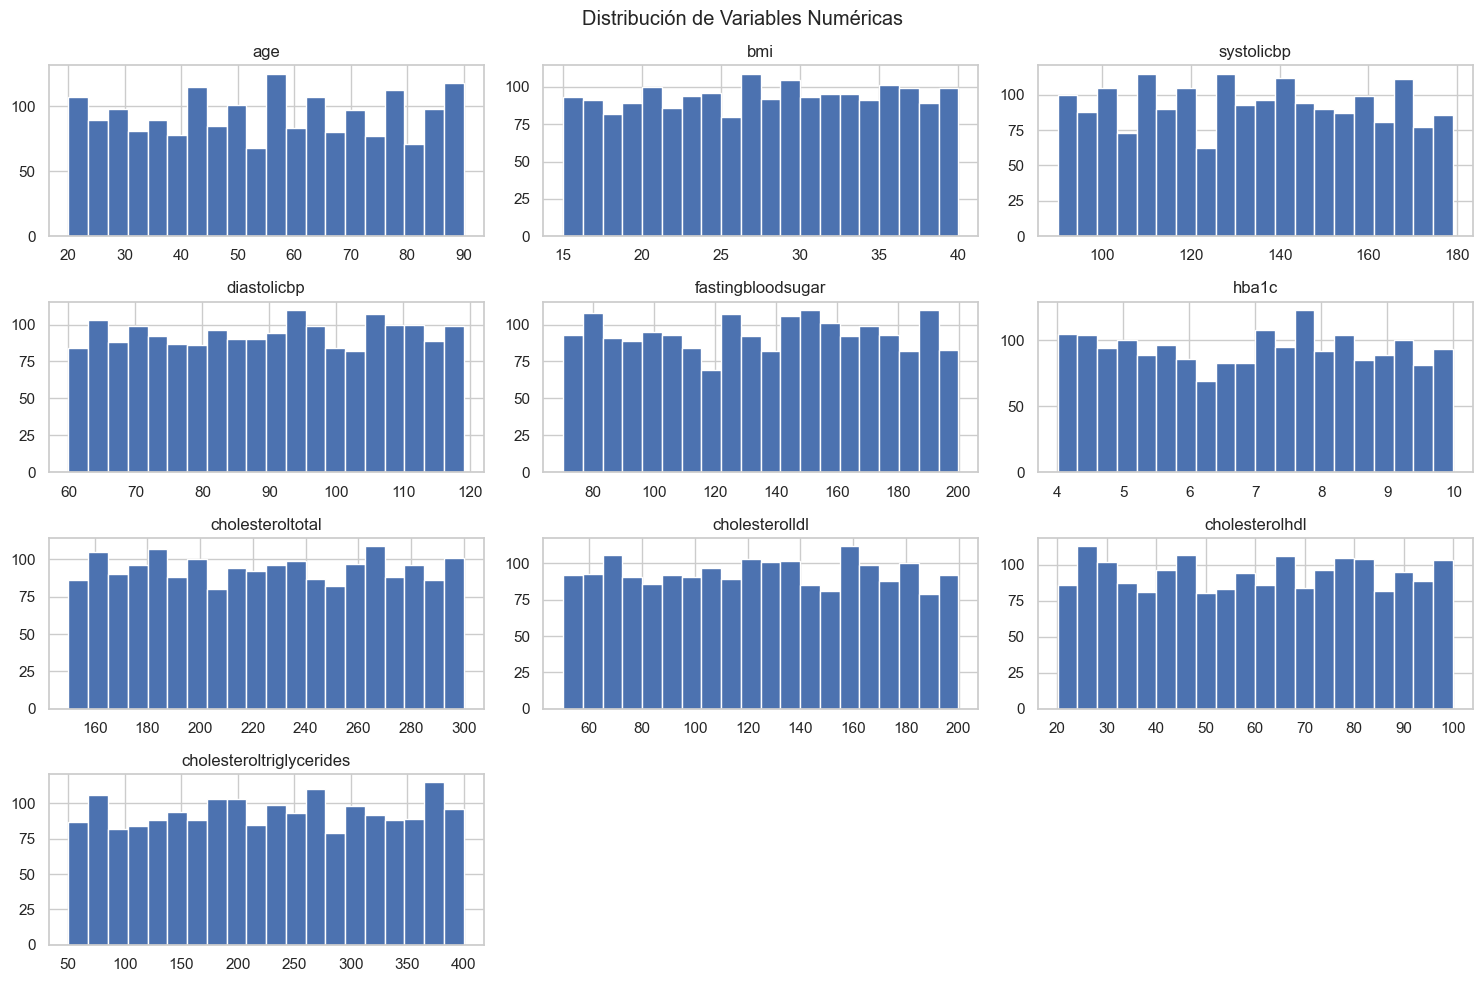

In [14]:
numerical_columns = ['age', 'bmi', 'systolicbp', 'diastolicbp', 'fastingbloodsugar', 'hba1c', 
                     'cholesteroltotal', 'cholesterolldl', 'cholesterolhdl', 'cholesteroltriglycerides']

df[numerical_columns].hist(bins=20, figsize=(15, 10), layout=(4, 3))
plt.suptitle('Distribución de Variables Numéricas')
plt.tight_layout()
plt.show()


<Figure size 1500x1000 with 0 Axes>

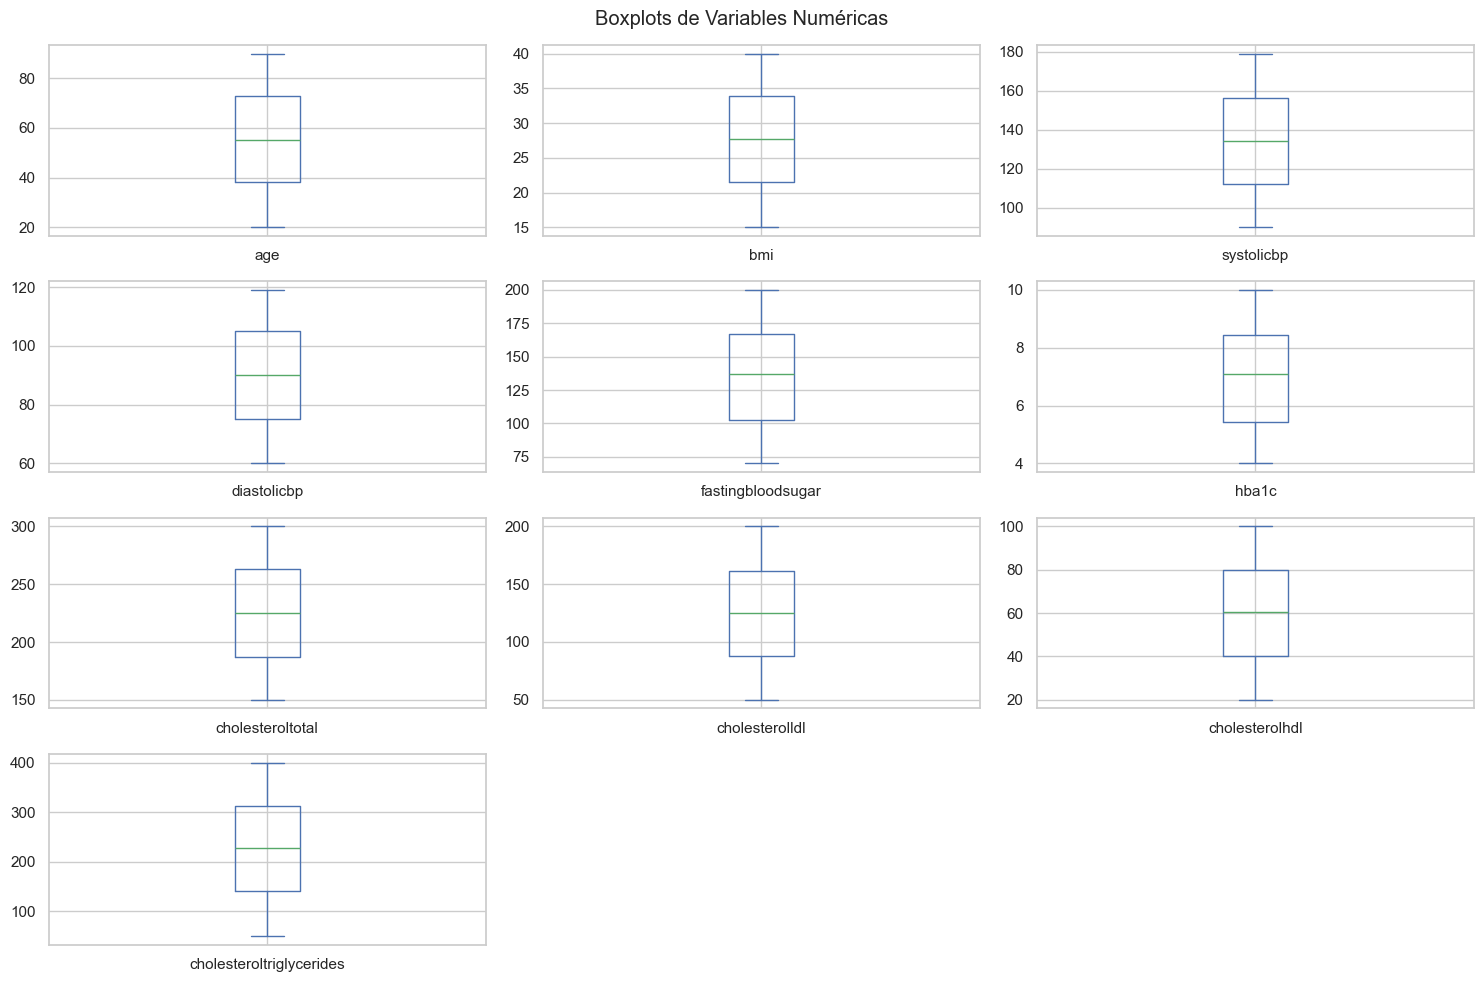

In [15]:
plt.figure(figsize=(15, 10))
df[numerical_columns].plot(kind='box', subplots=True, layout=(4, 3), sharex=False, sharey=False, figsize=(15, 10))
plt.suptitle('Boxplots de Variables Numéricas')
plt.tight_layout()
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_42220\1052021483.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="Set2")
C:\Users\USER\AppData\Local\Temp\ipykernel_42220\1052021483.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="Set2")
C:\Users\USER\AppData\Local\Temp\ipykernel_42220\1052021483.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, palette="Set2")
C:\Users\USER\AppData\Local\Temp\ipykernel_42220\1052021483.py:9: FutureWarning: 

Passing `palette` without 

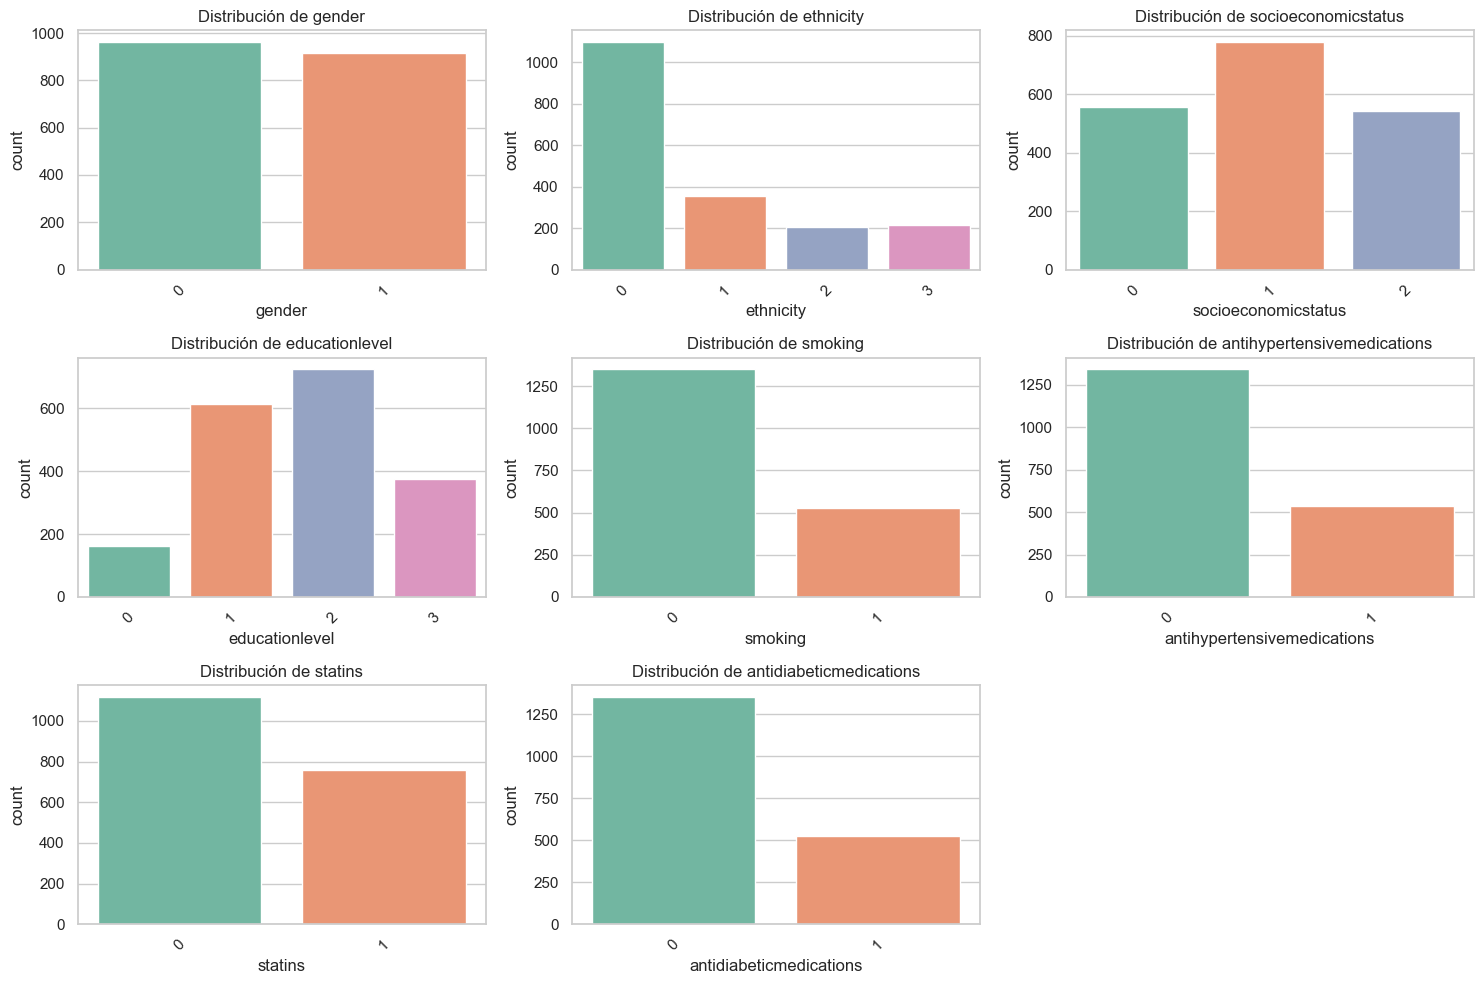

In [16]:
categorical_columns = ['gender', 'ethnicity', 'socioeconomicstatus', 'educationlevel', 'smoking', 
                       'antihypertensivemedications', 'statins', 'antidiabeticmedications']

plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=df, x=col, palette="Set2")
    plt.title(f'Distribución de {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

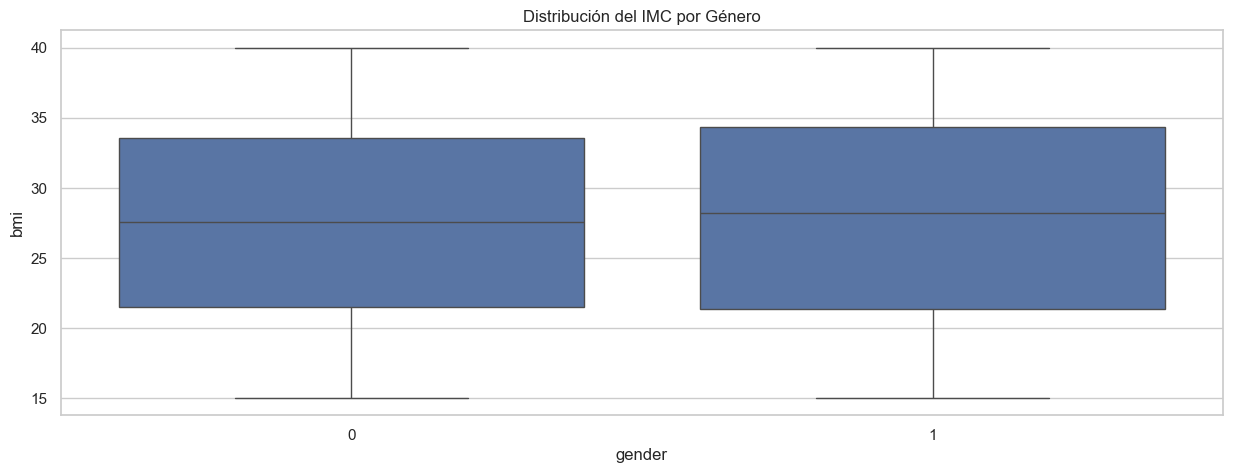

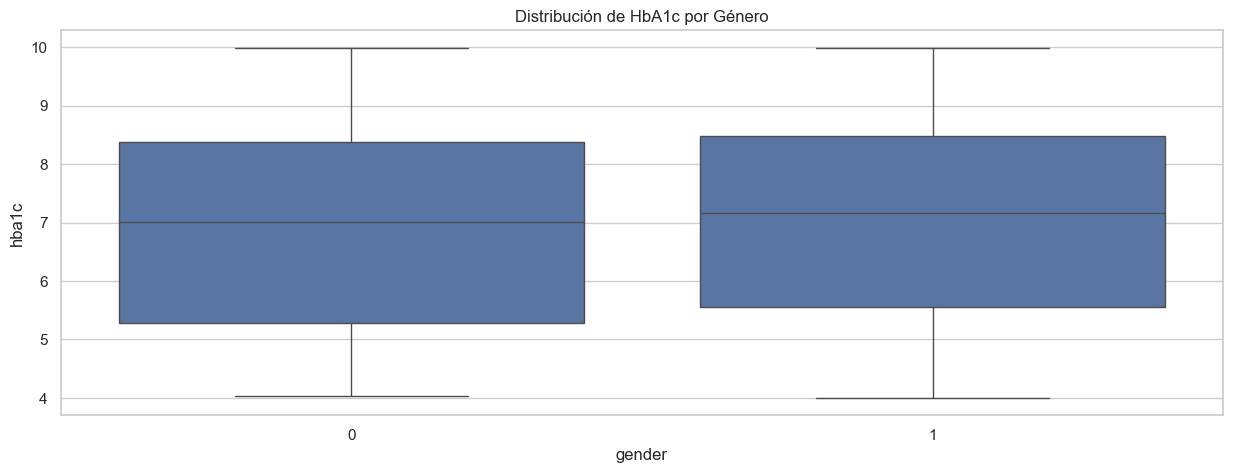

In [17]:
plt.figure(figsize=(15, 5))
sns.boxplot(x='gender', y='bmi', data=df)
plt.title('Distribución del IMC por Género')
plt.show()

plt.figure(figsize=(15, 5))
sns.boxplot(x='gender', y='hba1c', data=df)
plt.title('Distribución de HbA1c por Género')
plt.show()

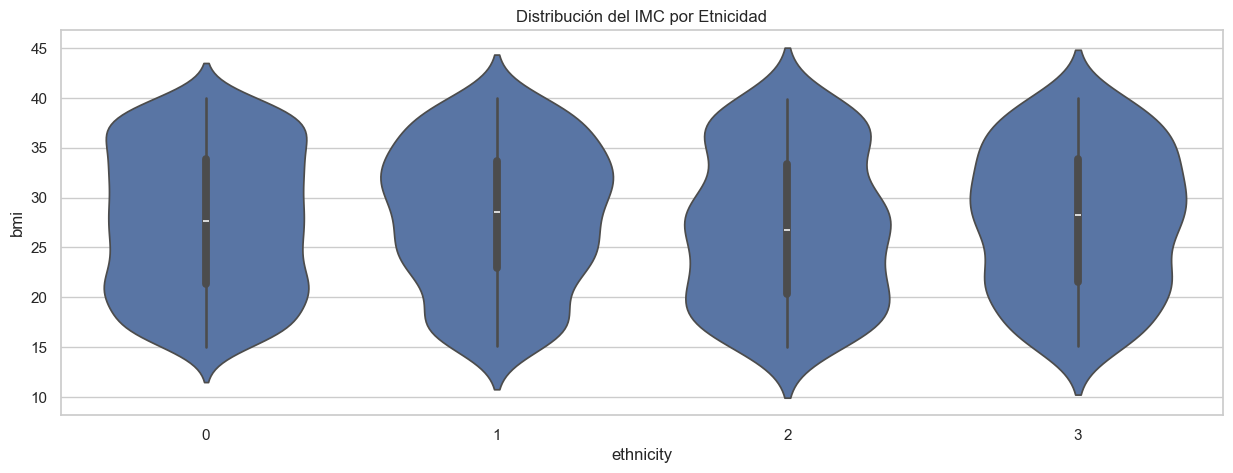

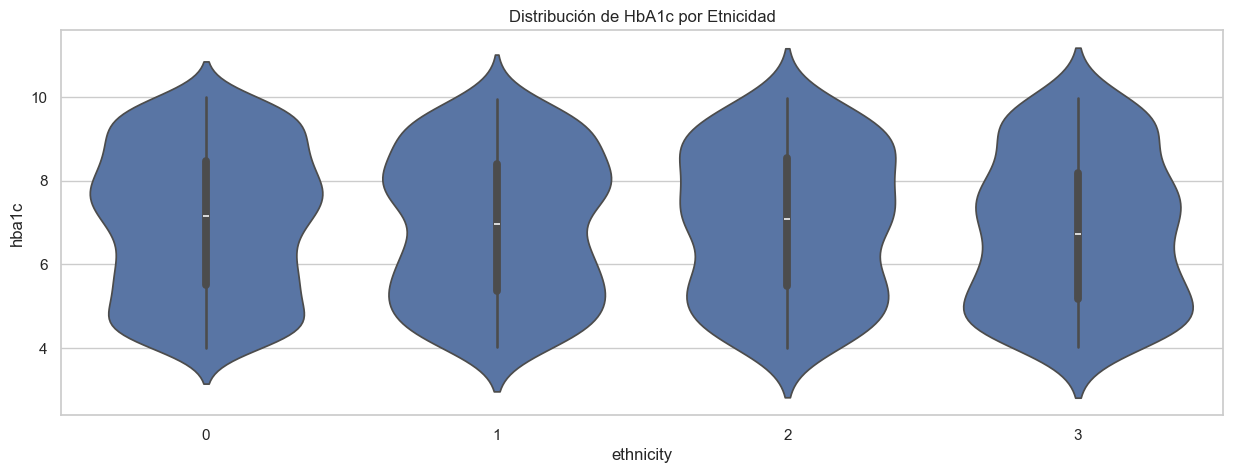

In [18]:
plt.figure(figsize=(15, 5))
sns.violinplot(x='ethnicity', y='bmi', data=df)
plt.title('Distribución del IMC por Etnicidad')
plt.show()

plt.figure(figsize=(15, 5))
sns.violinplot(x='ethnicity', y='hba1c', data=df)
plt.title('Distribución de HbA1c por Etnicidad')
plt.show()

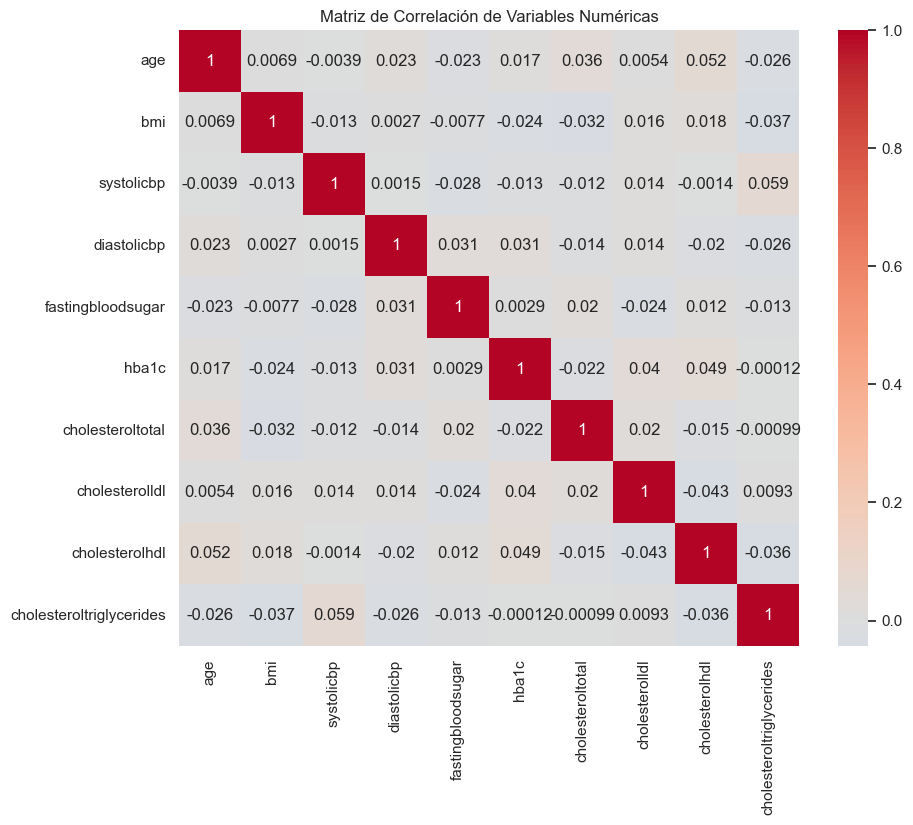

In [19]:
corr_matrix = df[numerical_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()